# Emotions GAM

Notebook para obtener las emociones que han despertado a los usuarios los cuadros de GAM. En este caso procedemos a:

1. Obtener la lista de emojis usados por los usuarios.
2. Cambiar los emojins por emociones de la escala de Plunchkin.
3. Crear el dataset final de emociones.

In [147]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import pandas as pd
import numpy as np

import emojis

In [3]:
from context import community_module
from community_module.community_detection.similarityCommunityDetection import SimilarityCommunityDetection
from community_module.community_detection.explainedCommunitiesDetection import ExplainedCommunitiesDetection
from community_module.visualization.gephiVisualization import GephiVisualization

from sklearn.metrics.pairwise import cosine_similarity
from community_module.similarity.artworkEmotionSimilarity import ArtworkEmotionSimilarity

In [4]:
interactions_df = pd.read_csv('../../data/GAM/clean_data/interactions.csv')

# Me quedo solo con las columnas user, artwork y q4 (emojis)
emojis_df = interactions_df[['user', 'artwork', 'q4']]
emojis_df.head()

user  artwork   q4
0     2        1  NaN
1     2        2  NaN
2     2        3  NaN
3     2        4  NaN
4     2        5  NaN

In [5]:
# Eliminamos filas NaN
emojis_df = emojis_df[~emojis_df.isna()['q4']]
emojis_df

user  artwork                                    q4
36       5        1     üòç feelings of love or infatuation
37       5        2                               relaxed
38       5        3                            üòï confused
39       5        4                            üòï confused
40       5        5                      üôÇ slightly happy
...    ...      ...                                   ...
1479   125        4                  üôÇ leggermente felice
1488   126        1            üòï confusione, ü§î pensieroso
1489   126        2                          tranquillit√†
1490   126        3                 üòï confusione, üò± paura
1491   126        4  üòç sentimenti di amore o infatuazione

[752 rows x 3 columns]

In [6]:
# Agrupamos por emojins
emojis_df.groupby(by='q4').count().sort_values(by='user', ascending=False)

user  artwork
q4                                 
ü§î thoughtful            27       27
üôÇ slightly happy        24       24
üôÇ leggermente felice    23       23
üòÑ felice                22       22
ü§î pensieroso            22       22
...                    ...      ...
investigative            1        1
inquietata               1        1
fire                     1        1
dolcezza                 1        1
üßê                        1        1

[348 rows x 2 columns]

In [7]:
emojis_df.tail(5)

user  artwork                                    q4
1479   125        4                  üôÇ leggermente felice
1488   126        1            üòï confusione, ü§î pensieroso
1489   126        2                          tranquillit√†
1490   126        3                 üòï confusione, üò± paura
1491   126        4  üòç sentimenti di amore o infatuazione

In [8]:
# extract emoji(s) from text
def get_emoji(text):
    #return emojis.get(text)
    # remove \u200d character in excel files
    #text = str(text.encode('ascii', 'ignore'))
    text = text.replace('\u200d','')
    #return emoji.distinct_emoji_list(text)
    return emojis.get(text)

In [9]:
emojis_df['emoji'] = emojis_df['q4'].apply(get_emoji)
emojis_df.head()

user  artwork                                 q4 emoji
36     5        1  üòç feelings of love or infatuation   {üòç}
37     5        2                            relaxed    {}
38     5        3                         üòï confused   {üòï}
39     5        4                         üòï confused   {üòï}
40     5        5                   üôÇ slightly happy   {üôÇ}

In [10]:
def has_emoji(emoji_column):
    return len(emoji_column) > 0

In [11]:
all_emojis = set().union(*list(emojis_df[emojis_df['emoji'].apply(has_emoji)]['emoji'].values))
all_emojis = list(all_emojis)
all_emojis

['ü§∑',
 'üõå',
 'ü§Ø',
 'üò¢',
 'üòè',
 '‚ôÄÔ∏è',
 'üòé',
 'ü§¢',
 'üò•',
 'üòÑ',
 '‚ù§Ô∏è',
 'üòç',
 'üíã',
 'üßê',
 'ü•∫',
 'üòî',
 'üëπ',
 'üòÇ',
 '‚ò∫Ô∏è',
 'üôÅ',
 'üò¨',
 'ü§´',
 'üò¥',
 'üôÇ',
 '‚ú®',
 'üò°',
 'ü•∞',
 'üë©',
 'ü§î',
 'üòå',
 'üå°Ô∏è',
 'üß†',
 'üôÑ',
 'ü§ê',
 'üòÆ',
 'üò±',
 'üòï',
 'üòä']

In [12]:
['‚ò∫Ô∏è',
 'üå°Ô∏è',
 'ü§î',
 'ü§ê',
 'üëπ',
 'üòî',
 'ü§∑',
 'üßê',
 'üò¢',
 'üôÇ',
 'üòÑ',
 '‚ú®',
 'üò¨',
 'ü•∫',
 'ü§´',
 'üß†',
 'üòé',
 'üòä',
 'ü•∞',
 '‚ù§Ô∏è',
 'üò±',
 'üòÆ',
 'üôÅ',
 'ü§Ø',
 'üë©',
 'üò¥',
 'üôÑ',
 'üõå',
 'üò°',
 'üò•',
 'üòï',
 'üòè',
 'ü§¢',
 'üòç',
 'üòÇ',
 '‚ôÄÔ∏è',
 'üòå',
 'üíã']

['‚ò∫Ô∏è',
 'üå°Ô∏è',
 'ü§î',
 'ü§ê',
 'üëπ',
 'üòî',
 'ü§∑',
 'üßê',
 'üò¢',
 'üôÇ',
 'üòÑ',
 '‚ú®',
 'üò¨',
 'ü•∫',
 'ü§´',
 'üß†',
 'üòé',
 'üòä',
 'ü•∞',
 '‚ù§Ô∏è',
 'üò±',
 'üòÆ',
 'üôÅ',
 'ü§Ø',
 'üë©',
 'üò¥',
 'üôÑ',
 'üõå',
 'üò°',
 'üò•',
 'üòï',
 'üòè',
 'ü§¢',
 'üòç',
 'üòÇ',
 '‚ôÄÔ∏è',
 'üòå',
 'üíã']

In [13]:
all_emojis[0]

'ü§∑'

In [14]:
# Voy a convertirlos a emociones con el dataset que se proporciona aqu√≠ https://github.com/abushoeb/EmoTag
#emotags_df = pd.read_csv('../../data/GAM/clean_data/EmoTag1200-scores.csv')
emotags_df = pd.read_csv('../../data/GAM/clean_data/EmoTag1200-scores-Copy1.csv')
emotags_df

unicode emoji              name  anger  anticipation  disgust  fear   joy  \
0     1F308     üåà           rainbow   0.69          0.28     0.00  0.69  0.69   
1     1F308     üåà           rainbow   0.00          0.28     0.00  0.00  0.69   
2     1F319     üåô     crescent moon   0.00          0.31     0.00  0.00  0.25   
3     1F31A     üåö     new moon face   0.06          0.08     0.17  0.06  0.42   
4     1F31E     üåû     sun with face   0.00          0.22     0.00  0.00  0.78   
..      ...   ...               ...    ...           ...      ...   ...   ...   
146    2757     ‚ùó  exclamation mark   0.44          0.42     0.31  0.42  0.08   
147    2764     ‚ù§         red heart   0.00          0.36     0.00  0.00  0.69   
148    27A1     ‚û°       right arrow   0.00          0.06     0.00  0.00  0.00   
149    2B05     ‚¨Ö        left arrow   0.17          0.14     0.17  0.14  0.00   
150    2B50     ‚≠ê              star   0.00          0.17     0.00  0.00  0.39   

     sadness  surprise  trust  
0       0.06      0.22   0.33  
1       0.06      0.22   0.33  
2       0.00      0.06   0.25  
3       0.19      0.06   0.11  
4       0.00      0.11   0.22  
..       ...       ...    ...  
146     0.17      0.81   0.11  
147     0.00      0.14   0.67  
148     0.00      0.00   0.22  
149     0.14      0.03   0.06  
150     0.00      0.17   0.22  

[151 rows x 11 columns]

In [15]:
emotags_df[emotags_df['emoji'] == all_emojis[2]]

Empty DataFrame
Columns: [unicode, emoji, name, anger, anticipation, disgust, fear, joy, sadness, surprise, trust]
Index: []

In [16]:
emojis_found = emotags_df[emotags_df['emoji'].isin(all_emojis)]['emoji'].values

In [17]:
print('Emojis que no se encuentran en el sentiment analysis')
set(all_emojis).difference(set(emojis_found))

Emojis que no se encuentran en el sentiment analysis


{'‚ò∫Ô∏è',
 '‚ôÄÔ∏è',
 '‚ù§Ô∏è',
 'üå°Ô∏è',
 'üë©',
 'üëπ',
 'üòÆ',
 'üôÅ',
 'üôÇ',
 'üôÑ',
 'üõå',
 'ü§ê',
 'ü§î',
 'ü§¢',
 'ü§´',
 'ü§Ø',
 'ü§∑',
 'ü•∞',
 'ü•∫',
 'üßê',
 'üß†'}

In [18]:
print('Emojis que si se encuentran en el sentiment analysis')
set(emojis_found)

Emojis que si se encuentran en el sentiment analysis


{'‚ú®',
 'üíã',
 'üòÇ',
 'üòÑ',
 'üòä',
 'üòå',
 'üòç',
 'üòé',
 'üòè',
 'üòî',
 'üòï',
 'üò°',
 'üò¢',
 'üò•',
 'üò¨',
 'üò±',
 'üò¥'}

In [19]:
emotags_df[emotags_df['emoji'].isin(emojis_found)]

unicode emoji                             name  anger  anticipation  \
38    1F48B     üíã                        kiss mark   0.00          0.28   
68    1F602     üòÇ           face with tears of joy   0.00          0.17   
70    1F604     üòÑ  grinning face with smiling eyes   0.00          0.36   
76    1F60A     üòä   smiling face with smiling eyes   0.00          0.42   
78    1F60C     üòå                    relieved face   0.00          0.33   
79    1F60D     üòç     smiling face with heart-eyes   0.00          0.31   
80    1F60E     üòé     smiling face with sunglasses   0.00          0.22   
81    1F60F     üòè                    smirking face   0.22          0.33   
86    1F614     üòî                     pensive face   0.25          0.22   
87    1F615     üòï                    confused face   0.19          0.42   
98    1F621     üò°                     pouting face   1.00          0.11   
99    1F622     üò¢                      crying face   0.25          0.08   
102   1F625     üò•            sad but relieved face   0.14          0.19   
107   1F62C     üò¨                   grimacing face   0.14          0.53   
110   1F631     üò±           face screaming in fear   0.28          0.42   
112   1F634     üò¥                    sleeping face   0.00          0.06   
143    2728     ‚ú®                         sparkles   0.00          0.36   

     disgust  fear   joy  sadness  surprise  trust  
38      0.00  0.00  0.78     0.00      0.19   0.69  
68      0.06  0.06  0.94     0.00      0.33   0.22  
70      0.00  0.00  0.86     0.00      0.28   0.28  
76      0.00  0.00  0.92     0.00      0.33   0.47  
78      0.00  0.11  0.81     0.00      0.22   0.61  
79      0.00  0.00  0.83     0.00      0.50   0.50  
80      0.00  0.00  0.75     0.00      0.06   0.33  
81      0.28  0.14  0.22     0.22      0.11   0.22  
86      0.31  0.28  0.00     0.72      0.19   0.14  
87      0.36  0.36  0.00     0.39      0.28   0.17  
98      0.56  0.11  0.00     0.36      0.08   0.06  
99      0.36  0.50  0.00     1.00      0.08   0.11  
102     0.25  0.33  0.03     0.81      0.08   0.06  
107     0.28  0.44  0.17     0.11      0.25   0.11  
110     0.42  0.92  0.06     0.25      0.69   0.11  
112     0.14  0.00  0.03     0.03      0.00   0.03  
143     0.00  0.06  0.53     0.00      0.44   0.31

In [20]:
not_found_emojis = list(set(all_emojis).difference(set(emojis_found)))
for em in not_found_emojis:
    data = emojis.db.get_emoji_by_code(em)
    #data = emoji.emojize(em)
    print(em, 'tags:', data.tags, 'aliases:', data.aliases)
#    print(emojis.db.get_emoji_by_code(em))


ü§∑ tags: [] aliases: ['shrug']
üõå tags: [] aliases: ['sleeping_bed']
ü§Ø tags: ['mind', 'blown'] aliases: ['exploding_head']
‚ôÄÔ∏è tags: [] aliases: ['female_sign']
ü§¢ tags: ['sick', 'barf', 'disgusted'] aliases: ['nauseated_face']
‚ù§Ô∏è tags: ['love'] aliases: ['heart']
üßê tags: [] aliases: ['monocle_face']
ü•∫ tags: ['puppy', 'eyes'] aliases: ['pleading_face']
üëπ tags: ['monster'] aliases: ['japanese_ogre']
‚ò∫Ô∏è tags: ['blush', 'pleased'] aliases: ['relaxed']
üôÅ tags: [] aliases: ['slightly_frowning_face']
ü§´ tags: ['silence', 'quiet'] aliases: ['shushing_face']
üôÇ tags: [] aliases: ['slightly_smiling_face']
ü•∞ tags: ['love'] aliases: ['smiling_face_with_three_hearts']
üë© tags: ['girls'] aliases: ['woman']
ü§î tags: [] aliases: ['thinking']
üå°Ô∏è tags: [] aliases: ['thermometer']
üß† tags: [] aliases: ['brain']
üôÑ tags: [] aliases: ['roll_eyes']
ü§ê tags: ['silence', 'hush'] aliases: ['zipper_mouth_face']
üòÆ tags: ['surprise', 'impressed', 'wow'] al

In [21]:
data = emojis.db.get_emoji_by_code('‚ò∫Ô∏è').aliases

In [22]:
data

['relaxed']

In [23]:
{
    'ü•∞': 'Love',
    'üßê': ''
}

{'ü•∞': 'Love', 'üßê': ''}

In [24]:
# My changes from here

In [25]:
emojis_df

user  artwork                                    q4   emoji
36       5        1     üòç feelings of love or infatuation     {üòç}
37       5        2                               relaxed      {}
38       5        3                            üòï confused     {üòï}
39       5        4                            üòï confused     {üòï}
40       5        5                      üôÇ slightly happy     {üôÇ}
...    ...      ...                                   ...     ...
1479   125        4                  üôÇ leggermente felice     {üôÇ}
1488   126        1            üòï confusione, ü§î pensieroso  {ü§î, üòï}
1489   126        2                          tranquillit√†      {}
1490   126        3                 üòï confusione, üò± paura  {üò±, üòï}
1491   126        4  üòç sentimenti di amore o infatuazione     {üòç}

[752 rows x 4 columns]

In [26]:
emojis_df.head(1)

user  artwork                                 q4 emoji
36     5        1  üòç feelings of love or infatuation   {üòç}

In [27]:
# Separate lists of emojis in different columns
emojis_df2 = emojis_df.set_index(['user', 'artwork', 'q4']).apply(lambda x: x.explode()).reset_index()
emojis_df2



user  artwork                                    q4 emoji
0        5        1     üòç feelings of love or infatuation     üòç
1        5        2                               relaxed   NaN
2        5        3                            üòï confused     üòï
3        5        4                            üòï confused     üòï
4        5        5                      üôÇ slightly happy     üôÇ
...    ...      ...                                   ...   ...
997    126        1            üòï confusione, ü§î pensieroso     üòï
998    126        2                          tranquillit√†   NaN
999    126        3                 üòï confusione, üò± paura     üò±
1000   126        3                 üòï confusione, üò± paura     üòï
1001   126        4  üòç sentimenti di amore o infatuazione     üòç

[1002 rows x 4 columns]

In [28]:
emojis_df2[(emojis_df2['user'] == 126)]

user  artwork                                    q4 emoji
996    126        1            üòï confusione, ü§î pensieroso     ü§î
997    126        1            üòï confusione, ü§î pensieroso     üòï
998    126        2                          tranquillit√†   NaN
999    126        3                 üòï confusione, üò± paura     üò±
1000   126        3                 üòï confusione, üò± paura     üòï
1001   126        4  üòç sentimenti di amore o infatuazione     üòç

In [29]:
# Get the emotion corresponding to each emoji




In [30]:
# Try to get user x artwork (values: list of emojis)
user_artwork_emojis = pd.pivot_table(emojis_df, values='emoji', index='user', columns='artwork', fill_value=0, aggfunc=np.sum)
user_artwork_emojis

artwork         1       2          3       4       5          6       7   \
user                                                                       
5              {üòç}      {}        {üòï}     {üòï}     {üôÇ}        {üòî}      {}   
6              {üò±}     {ü§î}        {üòï}     {üòç}     {üôÇ}        {üòî}     {ü§î}   
7           {üòÆ, ü§î}  {üôÇ, ü§î}     {ü§¢, üòî}     {üôÇ}     {üôÇ}     {üôÇ, ü§î}  {ü§î, üòå}   
8              {üôÇ}     {üòÑ}        {üò±}     {üòç}     {üòÑ}        {üò¥}     {üò¥}   
9        {üò±, üòÆ, ü§î}  {üôÇ, ü§î}     {ü§î, üòï}  {üò±, ü§î}  {ü§î, üòï}     {üòî, ü§î}     {üòç}   
...            ...     ...        ...     ...     ...        ...     ...   
122            {üòç}     {üôÇ}  {ü§î, üòî, üòï}  {üòç, ü§î}     {ü§î}  {üôÇ, üòÆ, ü§î}  {üôÇ, ü§î}   
123            {üôÇ}     {üòÑ}        {üòî}     {üòÆ}     {üôÇ}        {üòî}     {üò¢}   
124            {ü§î}       0        {ü§´}     {üò±}     {üôÇ}        {ü§î}      {}   
125            {üôÇ}     {üôÇ}        {ü§î}     {üôÇ}       0          0       0   
126         {ü§î, üòï}      {}     {üò±, üòï}     {üòç}       0          0       0   

artwork      8       9       10      11         12  
user                                                
5           {üôÇ}       0       0       0          0  
6            {}     {üòç}     {üò¥}     {üò¥}     {üò±, ü§¢}  
7        {üôÇ, üò¥}       0       0       0          0  
8           {üòï}       0       0       0          0  
9           {üò±}     {üôÇ}     {üò°}     {üôÇ}     {üò±, üòï}  
...         ...     ...     ...     ...        ...  
122      {üòç, üôÇ}  {üòç, üôÇ}     {ü§î}  {üôÇ, ü§î}  {üòî, üòÆ, ü§î}  
123         {üòÑ}     {üòç}  {ü§î, üò°}     {üòÑ}  {üò±, üòÆ, ü§î}  
124         {üò±}       0       0     {üòÑ}          0  
125           0       0       0       0          0  
126           0       0       0       0          0  

[122 rows x 12 columns]

In [31]:
# Try to get user x artwork (values: list of emotions based on the emojis)
user_artwork_emotions = pd.pivot_table(emojis_df2, values='emoji', index='user', columns='artwork', fill_value=0, aggfunc=np.sum)
user_artwork_emotions



artwork   1   2    3   4   5    6   7   8   9   10  11   12
user                                                       
5          üòç   0    üòï   üòï   üôÇ    üòî   0   üôÇ   0   0   0    0
6          üò±   ü§î    üòï   üòç   üôÇ    üòî   ü§î   0   üòç   üò¥   üò¥   üò±ü§¢
7         üòÆü§î  üôÇü§î   ü§¢üòî   üôÇ   üôÇ   üôÇü§î  ü§îüòå  üôÇüò¥   0   0   0    0
8          üôÇ   üòÑ    üò±   üòç   üòÑ    üò¥   üò¥   üòï   0   0   0    0
9        üò±üòÆü§î  üôÇü§î   ü§îüòï  üò±ü§î  ü§îüòï   üòîü§î   üòç   üò±   üôÇ   üò°   üôÇ   üò±üòï
...      ...  ..  ...  ..  ..  ...  ..  ..  ..  ..  ..  ...
122        üòç   üôÇ  ü§îüòîüòï  üòçü§î   ü§î  üôÇüòÆü§î  üôÇü§î  üòçüôÇ  üòçüôÇ   ü§î  üôÇü§î  üòîüòÆü§î
123        üôÇ   üòÑ    üòî   üòÆ   üôÇ    üòî   üò¢   üòÑ   üòç  ü§îüò°   üòÑ  üò±üòÆü§î
124        ü§î   0    ü§´   üò±   üôÇ    ü§î   0   üò±   0   0   üòÑ    0
125        üôÇ   üôÇ    ü§î   üôÇ   0    0   0   0   0   0   0    0
126       ü§îüòï   0   üò±üòï   üòç   0    0   0   0   0   0   0    0

[122 rows x 12 columns]

In [32]:
# For the user-artwork pairs with more than one emoji, separate them in different rows
# https://stackoverflow.com/questions/50731229/split-cell-into-multiple-rows-in-pandas-dataframe




In [33]:
# Get list of emotions for each user and artwork
#user_emotions = emojis_df.apply(lambda row: emotags_df[emotags_df['emoji'] == row['emoji']



#names_arts = interactions_df.apply(lambda row: artworks[artworks['_id'] == row['artworkID']].name.values[0], axis=1)



In [34]:
emotags_df

unicode emoji              name  anger  anticipation  disgust  fear   joy  \
0     1F308     üåà           rainbow   0.69          0.28     0.00  0.69  0.69   
1     1F308     üåà           rainbow   0.00          0.28     0.00  0.00  0.69   
2     1F319     üåô     crescent moon   0.00          0.31     0.00  0.00  0.25   
3     1F31A     üåö     new moon face   0.06          0.08     0.17  0.06  0.42   
4     1F31E     üåû     sun with face   0.00          0.22     0.00  0.00  0.78   
..      ...   ...               ...    ...           ...      ...   ...   ...   
146    2757     ‚ùó  exclamation mark   0.44          0.42     0.31  0.42  0.08   
147    2764     ‚ù§         red heart   0.00          0.36     0.00  0.00  0.69   
148    27A1     ‚û°       right arrow   0.00          0.06     0.00  0.00  0.00   
149    2B05     ‚¨Ö        left arrow   0.17          0.14     0.17  0.14  0.00   
150    2B50     ‚≠ê              star   0.00          0.17     0.00  0.00  0.39   

     sadness  surprise  trust  
0       0.06      0.22   0.33  
1       0.06      0.22   0.33  
2       0.00      0.06   0.25  
3       0.19      0.06   0.11  
4       0.00      0.11   0.22  
..       ...       ...    ...  
146     0.17      0.81   0.11  
147     0.00      0.14   0.67  
148     0.00      0.00   0.22  
149     0.14      0.03   0.06  
150     0.00      0.17   0.22  

[151 rows x 11 columns]

In [35]:
emojis_df2

user  artwork                                    q4 emoji
0        5        1     üòç feelings of love or infatuation     üòç
1        5        2                               relaxed   NaN
2        5        3                            üòï confused     üòï
3        5        4                            üòï confused     üòï
4        5        5                      üôÇ slightly happy     üôÇ
...    ...      ...                                   ...   ...
997    126        1            üòï confusione, ü§î pensieroso     üòï
998    126        2                          tranquillit√†   NaN
999    126        3                 üòï confusione, üò± paura     üò±
1000   126        3                 üòï confusione, üò± paura     üòï
1001   126        4  üòç sentimenti di amore o infatuazione     üòç

[1002 rows x 4 columns]

In [36]:
# Option 1 (simplified): assign the emotion with the highest value to each emoji
# https://stackoverflow.com/questions/36597732/find-column-with-the-highest-value-pandas
df = emotags_df
emotags_emotions_df = df.loc[:, ~df.columns.isin(['unicode', 'emoji','name','dominantEmotion'])]
emotags_df['dominantEmotion'] = emotags_emotions_df.idxmax(axis='columns')
emotags_df

unicode emoji              name  anger  anticipation  disgust  fear   joy  \
0     1F308     üåà           rainbow   0.69          0.28     0.00  0.69  0.69   
1     1F308     üåà           rainbow   0.00          0.28     0.00  0.00  0.69   
2     1F319     üåô     crescent moon   0.00          0.31     0.00  0.00  0.25   
3     1F31A     üåö     new moon face   0.06          0.08     0.17  0.06  0.42   
4     1F31E     üåû     sun with face   0.00          0.22     0.00  0.00  0.78   
..      ...   ...               ...    ...           ...      ...   ...   ...   
146    2757     ‚ùó  exclamation mark   0.44          0.42     0.31  0.42  0.08   
147    2764     ‚ù§         red heart   0.00          0.36     0.00  0.00  0.69   
148    27A1     ‚û°       right arrow   0.00          0.06     0.00  0.00  0.00   
149    2B05     ‚¨Ö        left arrow   0.17          0.14     0.17  0.14  0.00   
150    2B50     ‚≠ê              star   0.00          0.17     0.00  0.00  0.39   

     sadness  surprise  trust dominantEmotion  
0       0.06      0.22   0.33           anger  
1       0.06      0.22   0.33             joy  
2       0.00      0.06   0.25    anticipation  
3       0.19      0.06   0.11             joy  
4       0.00      0.11   0.22             joy  
..       ...       ...    ...             ...  
146     0.17      0.81   0.11        surprise  
147     0.00      0.14   0.67             joy  
148     0.00      0.00   0.22           trust  
149     0.14      0.03   0.06           anger  
150     0.00      0.17   0.22             joy  

[151 rows x 12 columns]

In [37]:
emotags_df[(emotags_df["name"] == 'confused face')]

unicode emoji           name  anger  anticipation  disgust  fear  joy  \
87   1F615     üòï  confused face   0.19          0.42     0.36  0.36  0.0   

    sadness  surprise  trust dominantEmotion  
87     0.39      0.28   0.17    anticipation

In [38]:
emojis_df2

user  artwork                                    q4 emoji
0        5        1     üòç feelings of love or infatuation     üòç
1        5        2                               relaxed   NaN
2        5        3                            üòï confused     üòï
3        5        4                            üòï confused     üòï
4        5        5                      üôÇ slightly happy     üôÇ
...    ...      ...                                   ...   ...
997    126        1            üòï confusione, ü§î pensieroso     üòï
998    126        2                          tranquillit√†   NaN
999    126        3                 üòï confusione, üò± paura     üò±
1000   126        3                 üòï confusione, üò± paura     üòï
1001   126        4  üòç sentimenti di amore o infatuazione     üòç

[1002 rows x 4 columns]

In [39]:
# Add the dominant emotion to the user - artwork - emoji data
user_artwork_emojis_df = emojis_df2.merge(emotags_df[['emoji','dominantEmotion']])
user_artwork_emojis_df

user  artwork                                                 q4 emoji  \
0       5        1                  üòç feelings of love or infatuation     üòç   
1       6        4                  üòç feelings of love or infatuation     üòç   
2       6        9                  üòç feelings of love or infatuation     üòç   
3       8        4                  üòç feelings of love or infatuation     üòç   
4       9        7                  üòç feelings of love or infatuation     üòç   
..    ...      ...                                                ...   ...   
472   102        7                                                  üòä     üòä   
473    80        3                                                  üòè     üòè   
474   104        1                                                  üò¨     üò¨   
475   112        4  üòç sentimenti di amore o infatuazione, üôÇ legger...     ‚ú®   
476   123        7                                                  üò¢     üò¢   

    dominantEmotion  
0               joy  
1               joy  
2               joy  
3               joy  
4               joy  
..              ...  
472             joy  
473    anticipation  
474    anticipation  
475             joy  
476         sadness  

[477 rows x 5 columns]

In [40]:
search_df = user_artwork_emojis_df[(user_artwork_emojis_df["user"] == 121)]
search_df

user  artwork                          q4 emoji dominantEmotion
152   121        1  üòï confusione, ü§î pensieroso     üòï    anticipation
153   121        4                üòï confusione     üòï    anticipation
154   121        7        üòï confusione, üò¥ noia     üòï    anticipation
254   121        5       üòÑ felice, üòî tristezza     üòî         sadness
358   121        7        üòï confusione, üò¥ noia     üò¥         disgust
432   121        5       üòÑ felice, üòî tristezza     üòÑ             joy

In [41]:
# user x artwork (values: list of emotions based on the emojis)
#user_artwork_emotions_df = pd.pivot_table(user_artwork_emojis_df, values='dominantEmotion', index='user', columns='artwork', fill_value=np.NaN, aggfunc=np.sum)
#user_artwork_emotions_df = pd.pivot_table(user_artwork_emojis_df, values='dominantEmotion', index='user', columns='artwork', fill_value=np.NaN, aggfunc=pd.Series.tolist)
user_artwork_emotions_df = pd.pivot_table(user_artwork_emojis_df, values='dominantEmotion', index='user', columns='artwork', fill_value=np.NaN, aggfunc=lambda x: ', '.join(x))



user_artwork_emotions_df


artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [42]:
df = user_artwork_emotions_df
df

artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [43]:
user_artwork_emotions_df = df.head(15)
user_artwork_emotions_df = df
user_artwork_emotions_df

artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [44]:
# Calculate similarity based on that
community_detection = ExplainedCommunitiesDetection(user_artwork_emotions_df, SimilarityCommunityDetection, ArtworkEmotionSimilarity)

In [45]:
#n_communities, users_communities = community_detection.search_all_communities(percentage=0.78)
n_communities, users_communities = community_detection.search_all_communities(percentage=0.35)
users_communities
#p = 7

{5: 1,
 6: 1,
 7: 0,
 8: 0,
 9: 1,
 11: 4,
 12: 1,
 13: 0,
 14: 1,
 15: 1,
 16: 4,
 17: 0,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 3,
 28: 0,
 29: 0,
 30: 1,
 31: 1,
 32: 0,
 34: 0,
 35: 0,
 36: 1,
 37: 0,
 39: 0,
 41: 1,
 44: 4,
 45: 0,
 54: 1,
 58: 0,
 61: 1,
 63: 1,
 64: 4,
 65: 0,
 66: 4,
 67: 4,
 68: 1,
 69: 1,
 70: 0,
 71: 0,
 72: 0,
 73: 1,
 74: 0,
 75: 0,
 76: 4,
 77: 0,
 78: 0,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 84: 0,
 85: 1,
 87: 0,
 88: 3,
 89: 1,
 90: 4,
 91: 2,
 92: 1,
 93: 1,
 94: 0,
 95: 3,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 101: 1,
 102: 0,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 0,
 108: 4,
 109: 1,
 110: 1,
 111: 4,
 112: 1,
 113: 4,
 114: 0,
 115: 1,
 116: 0,
 117: 1,
 118: 1,
 119: 4,
 120: 0,
 121: 0,
 122: 1,
 123: 0,
 124: 1,
 126: 1}

In [46]:
similarityData = user_artwork_emotions_df.copy()#user_artwork_emotions_df.iloc[:,0:-1]
similarityData

artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [47]:
# Calculate distances
# I dont think cosine similarity is the one we should go for since we are using emotion similarity
#distances = cosine_similarity(data)
# Thus, we directly use ArtworkEmotionSimilarity to get the distances
similarityMeasure = ArtworkEmotionSimilarity(similarityData)
distances = similarityMeasure.matrix_distance()
distances



array([[0.        , 0.1875    , 0.75      , ..., 0.375     , 0.75      ,
        0.16666667],
       [0.1875    , 0.        , 0.75      , ..., 0.29166667, 0.625     ,
        0.25      ],
       [0.75      , 0.75      , 0.        , ..., 0.58333333, 0.75      ,
        0.75      ],
       ...,
       [0.375     , 0.29166667, 0.58333333, ..., 0.        , 0.25      ,
        0.75      ],
       [0.75      , 0.625     , 0.75      , ..., 0.25      , 0.        ,
        0.5       ],
       [0.16666667, 0.25      , 0.75      , ..., 0.75      , 0.5       ,
        0.        ]])

In [48]:
# User artwork emotions is changed
user_artwork_communities_df = user_artwork_emotions_df
user_artwork_communities_df['community'] = users_communities.values()
user_artwork_emotions_df.reset_index(inplace=True)
user_artwork_emotions_df

artwork  user             1    2                      3             4  \
0           5           joy  NaN           anticipation  anticipation   
1           6          fear  NaN           anticipation           joy   
2           7           NaN  NaN                sadness           NaN   
3           8           NaN  joy                   fear           joy   
4           9          fear  NaN           anticipation          fear   
..        ...           ...  ...                    ...           ...   
92        121  anticipation  NaN                    NaN  anticipation   
93        122           joy  NaN  anticipation, sadness           joy   
94        123           NaN  joy                sadness           NaN   
95        124           NaN  NaN                    NaN          fear   
96        126  anticipation  NaN     anticipation, fear           joy   

artwork             5        6                      7             8    9  \
0                 NaN  sadness                    NaN           NaN  NaN   
1                 NaN  sadness                    NaN           NaN  joy   
2                 NaN      NaN                    joy       disgust  NaN   
3                 joy  disgust                disgust  anticipation  NaN   
4        anticipation  sadness                    joy          fear  NaN   
..                ...      ...                    ...           ...  ...   
92       sadness, joy      NaN  anticipation, disgust           NaN  NaN   
93                NaN      NaN                    NaN           joy  joy   
94                NaN  sadness                sadness           joy  joy   
95                NaN      NaN                    NaN          fear  NaN   
96                NaN      NaN                    NaN           NaN  NaN   

artwork       10       11                  12  community  
0            NaN      NaN                 NaN          1  
1        disgust  disgust                fear          1  
2            NaN      NaN                 NaN          0  
3            NaN      NaN                 NaN          0  
4          anger      NaN  anticipation, fear          1  
..           ...      ...                 ...        ...  
92           NaN      NaN                 NaN          0  
93           NaN      NaN             sadness          1  
94         anger      joy                fear          0  
95           NaN      joy                 NaN          1  
96           NaN      NaN                 NaN          1  

[97 rows x 14 columns]

In [49]:
# Preparamos los datos de usuarios y distancias
users = user_artwork_emotions_df[['user','community']].values
data = user_artwork_emotions_df.iloc[:,1:-1].values
#data = plutchickEmotion(data)
data

array([['joy', nan, 'anticipation', ..., nan, nan, nan],
       ['fear', nan, 'anticipation', ..., 'disgust', 'disgust', 'fear'],
       [nan, nan, 'sadness', ..., nan, nan, nan],
       ...,
       [nan, 'joy', 'sadness', ..., 'anger', 'joy', 'fear'],
       [nan, nan, nan, ..., nan, 'joy', nan],
       ['anticipation', nan, 'anticipation, fear', ..., nan, nan, nan]],
      dtype=object)

In [50]:
# https://stackoverflow.com/questions/17950374/converting-a-column-within-pandas-dataframe-from-int-to-string
users_df = pd.DataFrame(users, columns=['user','community'])
users_df['user'] = users_df['user'].apply(str)
users_df
users2 = users_df[['user','community']].values
users2

array([['5', 1],
       ['6', 1],
       ['7', 0],
       ['8', 0],
       ['9', 1],
       ['11', 4],
       ['12', 1],
       ['13', 0],
       ['14', 1],
       ['15', 1],
       ['16', 4],
       ['17', 0],
       ['18', 1],
       ['19', 1],
       ['20', 1],
       ['21', 1],
       ['23', 1],
       ['24', 1],
       ['25', 1],
       ['26', 1],
       ['27', 3],
       ['28', 0],
       ['29', 0],
       ['30', 1],
       ['31', 1],
       ['32', 0],
       ['34', 0],
       ['35', 0],
       ['36', 1],
       ['37', 0],
       ['39', 0],
       ['41', 1],
       ['44', 4],
       ['45', 0],
       ['54', 1],
       ['58', 0],
       ['61', 1],
       ['63', 1],
       ['64', 4],
       ['65', 0],
       ['66', 4],
       ['67', 4],
       ['68', 1],
       ['69', 1],
       ['70', 0],
       ['71', 0],
       ['72', 0],
       ['73', 1],
       ['74', 0],
       ['75', 0],
       ['76', 4],
       ['77', 0],
       ['78', 0],
       ['79', 1],
       ['80', 1],
       ['81', 1

In [51]:
# Pintamos en Gephi
gv = GephiVisualization(workspace='gam_emojis')
gv.load_community(users2, distances, users_properties=['community'])

ConnectionRefusedError: [WinError 10061] No se puede establecer una conexi√≥n ya que el equipo de destino deneg√≥ expresamente dicha conexi√≥n

In [53]:
user_artwork_emotions_df[['user','community']]

artwork  user  community
0           5          1
1           6          1
2           7          0
3           8          0
4           9          1
..        ...        ...
92        121          0
93        122          1
94        123          0
95        124          1
96        126          1

[97 rows x 2 columns]

In [54]:
n_communities

5

In [55]:
community_data = community_detection.get_community(0, answer_binary=False,percentage=0.35)
#community_data

In [56]:
users_without_community = []
for c in range(n_communities):
    community_data = community_detection.get_community(c, answer_binary=False,percentage=0.35)

    if len(community_data['members']) > 1:

        print('---------------------')
        print('COMMUNITY -', community_data['name'])
        print('\t- N. Members:', len(community_data['members']))
        print('\t- Properties:')

        for k in community_data['properties'].keys():
            #print('\t\t-', k)
            print('\t\t-', k, community_data['properties'][k])
    else:
        users_without_community.extend(community_data['members'])

print('---------------------')
print('N. USERS WITHOUT COMMUNITY -', len(users_without_community))

---------------------
COMMUNITY - 0
	- N. Members: 35
	- Properties:
		- 2 joy
		- 3 sadness
---------------------
COMMUNITY - 1
	- N. Members: 46
	- Properties:
		- 3 anticipation
---------------------
COMMUNITY - 3
	- N. Members: 3
	- Properties:
		- 1 sadness
		- 4 sadness
		- 6 sadness
---------------------
COMMUNITY - 4
	- N. Members: 12
	- Properties:
		- 1 sadness
		- 2 disgust
		- 4 joy
---------------------
N. USERS WITHOUT COMMUNITY - 1


In [57]:
#-----------------------------------------------------------------------------------------------------------------
#          k-medoids (example)
#-----------------------------------------------------------------------------------------------------------------



In [58]:
from sklearn.metrics.pairwise import pairwise_distances
import numpy as np

In [59]:
import kmedoids

In [60]:
# 3 points in dataset
data = np.array([[1,1], 
                [2,2], 
                [10,10]])

In [61]:
# distance matrix
D = pairwise_distances(data, metric='euclidean')
D

array([[ 0.        ,  1.41421356, 12.72792206],
       [ 1.41421356,  0.        , 11.3137085 ],
       [12.72792206, 11.3137085 ,  0.        ]])

In [62]:
# split into 2 clusters
M, C = kmedoids.kMedoids(D, 2)

[0.]
[5.65685425 5.65685425]


In [63]:
M

array([0, 1])

In [64]:
C

{0: array([0], dtype=int64), 1: array([1, 2], dtype=int64)}

In [65]:
print('medoids:')
for point_idx in M:
    print(point_idx)
    print( data[point_idx] )

medoids:
0
[1 1]
1
[2 2]


In [66]:

print('')
print('clustering result:')
for label in C:
    for point_idx in C[label]:
        print('label {0}:„ÄÄ{1}'.format(label, data[point_idx]))


clustering result:
label 0:„ÄÄ[1 1]
label 1:„ÄÄ[2 2]
label 1:„ÄÄ[10 10]


In [67]:
#-----------------------------------------------------------------------------------------------------------------
#          k-medoids
#-----------------------------------------------------------------------------------------------------------------

similarityData

artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [68]:
# distance matrix for artworkEmotionSimilarity
# Thus, we directly use ArtworkEmotionSimilarity to get the distances
similarityMeasure = ArtworkEmotionSimilarity(similarityData)
artworkEmotionDistanceMatrix = similarityMeasure.matrix_distance()
artworkEmotionDistanceMatrix



array([[0.        , 0.1875    , 0.75      , ..., 0.375     , 0.75      ,
        0.16666667],
       [0.1875    , 0.        , 0.75      , ..., 0.29166667, 0.625     ,
        0.25      ],
       [0.75      , 0.75      , 0.        , ..., 0.58333333, 0.75      ,
        0.75      ],
       ...,
       [0.375     , 0.29166667, 0.58333333, ..., 0.        , 0.25      ,
        0.75      ],
       [0.75      , 0.625     , 0.75      , ..., 0.25      , 0.        ,
        0.5       ],
       [0.16666667, 0.25      , 0.75      , ..., 0.75      , 0.5       ,
        0.        ]])

In [69]:
# split into 2 clusters
#M, C = kmedoids.kMedoids(artworkEmotionDistanceMatrix, 5)

In [70]:
M

array([0, 1])

In [71]:
C

{0: array([0], dtype=int64), 1: array([1, 2], dtype=int64)}

In [72]:
print('medoids:')
for point_idx in M:
    print(point_idx)
    print( similarityData.iloc[point_idx] )

medoids:
0
artwork
1              joy
2              NaN
3     anticipation
4     anticipation
5              NaN
6          sadness
7              NaN
8              NaN
9              NaN
10             NaN
11             NaN
12             NaN
Name: 5, dtype: object
1
artwork
1             fear
2              NaN
3     anticipation
4              joy
5              NaN
6          sadness
7              NaN
8              NaN
9              joy
10         disgust
11         disgust
12            fear
Name: 6, dtype: object


In [73]:
"""
print('')
print('clustering result:')
for label in C:
    for point_idx in C[label]:
        print(point_idx)
        print('label {0}:„ÄÄ{1}'.format(label, similarityData.iloc[point_idx]))
"""


"\nprint('')\nprint('clustering result:')\nfor label in C:\n    for point_idx in C[label]:\n        print(point_idx)\n        print('label {0}:\u3000{1}'.format(label, similarityData.iloc[point_idx]))\n"

In [74]:
C

{0: array([0], dtype=int64), 1: array([1, 2], dtype=int64)}

In [75]:

# change cluster labels to dataframe
# https://stackoverflow.com/questions/43634548/dictionary-containing-arrays-and-matrices-to-pandas-dataframe

In [76]:
# Add cluster
similarityDataCluster = similarityData.copy()
similarityDataCluster['cluster'] = np.nan
similarityDataCluster['cluster'] = similarityDataCluster.index
#similarityDataCluster

In [77]:
#print(similarityDataCluster.index)
8

8

In [78]:
for label in C:
    for point_idx in C[label]:
        #print(point_idx)
        #print(similarityDataCluster.index[point_idx])
        #print(similarityDataCluster.loc[similarityDataCluster.index[point_idx],'cluster'])
        #print("\n\n\n")
        similarityDataCluster.loc[similarityDataCluster.index[point_idx],'cluster'] = label
        

        #print(point_idx)
        #print('label {0}:„ÄÄ{1}'.format(label, similarityData.iloc[point_idx]))
#similarityDataCluster['cluster'] = similarityDataCluster['cluster'].astype(int)
#similarityDataCluster.dropna()
similarityDataCluster

artwork             1    2                      3             4             5  \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork        6                      7             8    9       10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  cluster  
user                                  
5                       NaN        0  
6                      fear        1  
7                       NaN        1  
8                       NaN        8  
9        anticipation, fear        9  
...                     ...      ...  
121                     NaN      121  
122                 sadness      122  
123                    fear      123  
124                     NaN      124  
126                     NaN      126  

[97 rows x 13 columns]

In [79]:
similarityData.iloc[14]

artwork
1     anticipation, sadness, anger
2                     anticipation
3                     anticipation
4     anticipation, sadness, anger
5      anticipation, sadness, fear
6      anticipation, sadness, fear
7                              joy
8                     anticipation
9                              NaN
10                             NaN
11                             NaN
12                             NaN
Name: 20, dtype: object

In [80]:
similarityData.head(15)

artwork                            1             2                    3   \
user                                                                       
5                                 joy           NaN         anticipation   
6                                fear           NaN         anticipation   
7                                 NaN           NaN              sadness   
8                                 NaN           joy                 fear   
9                                fear           NaN         anticipation   
11                            sadness           NaN  anticipation, anger   
12              anticipation, sadness           joy         anticipation   
13                                NaN           joy              sadness   
14                                NaN           NaN   anticipation, fear   
15                                NaN      joy, joy             joy, joy   
16                                NaN       sadness                  NaN   
17                                NaN           NaN                  NaN   
18                 anticipation, fear           NaN                  joy   
19                       anticipation           joy                  joy   
20       anticipation, sadness, anger  anticipation         anticipation   

artwork                            4                            5   \
user                                                                 
5                        anticipation                          NaN   
6                                 joy                          NaN   
7                                 NaN                          NaN   
8                                 joy                          joy   
9                                fear                 anticipation   
11                                NaN                          NaN   
12                                NaN           anticipation, fear   
13              anticipation, sadness                          NaN   
14                       anticipation                      disgust   
15                       anticipation                 sadness, joy   
16                                joy                      disgust   
17                                joy                          NaN   
18         joy, anticipation, sadness                          NaN   
19                       anticipation                          NaN   
20       anticipation, sadness, anger  anticipation, sadness, fear   

artwork                           6             7              8        9   \
user                                                                         
5                            sadness           NaN            NaN      NaN   
6                            sadness           NaN            NaN      joy   
7                                NaN           joy        disgust      NaN   
8                            disgust       disgust   anticipation      NaN   
9                            sadness           joy           fear      NaN   
11                               NaN           NaN            NaN      NaN   
12                anticipation, fear  sadness, joy            NaN      NaN   
13       anticipation, sadness, fear           joy  sadness, fear      NaN   
14                           sadness           NaN            NaN  disgust   
15             anticipation, sadness           joy            NaN      NaN   
16                               NaN           NaN          anger      NaN   
17                           disgust           NaN            NaN      NaN   
18                               NaN           NaN            NaN      NaN   
19                           sadness           NaN            NaN      NaN   
20       anticipation, sadness, fear           joy   anticipation      NaN   

artwork            10       11                  12  
user                                                
5                 NaN      NaN                 NaN  
6             disgust  disgust

In [81]:
#-----------------------------------------------------------------------------------------------------------------
#          k-medoids (real deal) pyclustering
#-----------------------------------------------------------------------------------------------------------------



In [83]:
PLUTCHIK_EMOTIONS = ['anger', 'anticipation', 'joy', 'trust', 'fear', 'surprise', 'sadness', 'disgust']
counter = 0
def plutchikEmotionIndex(emotion):
    global counter
    print("\ncounter: " + str(counter))
    counter += 1
    if pd.isna(emotion):
        print("nan")
        return emotion
    elif(PLUTCHIK_EMOTIONS.index(emotion)):
        #print(emotion)
        print('emotion: ' + str(emotion))
        #print("dragon")
        result = PLUTCHIK_EMOTIONS.index(emotion)
        #print("hey")
        #print("phoenix")
        print('result: ' + str(result))
        return result

In [84]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.apply.html
# https://stackoverflow.com/questions/41708059/python-pandas-selecting-1st-element-in-array-in-all-cells

similarityData2 = similarityData.copy()
similarityData2 = similarityData2.iloc[:,0:].apply(lambda x: x.str.split(pat=', ',expand=False).str[0], axis=1)
similarityData2

artwork            1    2             3             4             5        6   \
user                                                                            
5                 joy  NaN  anticipation  anticipation           NaN  sadness   
6                fear  NaN  anticipation           joy           NaN  sadness   
7                 NaN  NaN       sadness           NaN           NaN      NaN   
8                 NaN  joy          fear           joy           joy  disgust   
9                fear  NaN  anticipation          fear  anticipation  sadness   
...               ...  ...           ...           ...           ...      ...   
121      anticipation  NaN           NaN  anticipation       sadness      NaN   
122               joy  NaN  anticipation           joy           NaN      NaN   
123               NaN  joy       sadness           NaN           NaN  sadness   
124               NaN  NaN           NaN          fear           NaN      NaN   
126      anticipation  NaN  anticipation           joy           NaN      NaN   

artwork            7             8    9        10       11            12  
user                                                                      
5                 NaN           NaN  NaN      NaN      NaN           NaN  
6                 NaN           NaN  joy  disgust  disgust          fear  
7                 joy       disgust  NaN      NaN      NaN           NaN  
8             disgust  anticipation  NaN      NaN      NaN           NaN  
9                 joy          fear  NaN    anger      NaN  anticipation  
...               ...           ...  ...      ...      ...           ...  
121      anticipation           NaN  NaN      NaN      NaN           NaN  
122               NaN           joy  joy      NaN      NaN       sadness  
123           sadness           joy  joy    anger      joy          fear  
124               NaN          fear  NaN      NaN      joy           NaN  
126               NaN           NaN  NaN      NaN      NaN           NaN  

[97 rows x 12 columns]

In [85]:
similarityData2.iloc[0:,:]

artwork            1    2             3             4             5        6   \
user                                                                            
5                 joy  NaN  anticipation  anticipation           NaN  sadness   
6                fear  NaN  anticipation           joy           NaN  sadness   
7                 NaN  NaN       sadness           NaN           NaN      NaN   
8                 NaN  joy          fear           joy           joy  disgust   
9                fear  NaN  anticipation          fear  anticipation  sadness   
...               ...  ...           ...           ...           ...      ...   
121      anticipation  NaN           NaN  anticipation       sadness      NaN   
122               joy  NaN  anticipation           joy           NaN      NaN   
123               NaN  joy       sadness           NaN           NaN  sadness   
124               NaN  NaN           NaN          fear           NaN      NaN   
126      anticipation  NaN  anticipation           joy           NaN      NaN   

artwork            7             8    9        10       11            12  
user                                                                      
5                 NaN           NaN  NaN      NaN      NaN           NaN  
6                 NaN           NaN  joy  disgust  disgust          fear  
7                 joy       disgust  NaN      NaN      NaN           NaN  
8             disgust  anticipation  NaN      NaN      NaN           NaN  
9                 joy          fear  NaN    anger      NaN  anticipation  
...               ...           ...  ...      ...      ...           ...  
121      anticipation           NaN  NaN      NaN      NaN           NaN  
122               NaN           joy  joy      NaN      NaN       sadness  
123           sadness           joy  joy    anger      joy          fear  
124               NaN          fear  NaN      NaN      joy           NaN  
126               NaN           NaN  NaN      NaN      NaN           NaN  

[97 rows x 12 columns]

In [86]:
counter = 0
# https://stackoverflow.com/questions/39475978/apply-function-to-each-cell-in-dataframe
# df.apply(np.vectorize(foo_bar))
# For some reason, i cannot pass int,float so i just passed float (for nan)
similarityData3 = similarityData2.iloc[0:,0:].apply(np.vectorize(plutchikEmotionIndex,otypes=[float]))
similarityData3


counter: 0
emotion: joy
result: 2

counter: 1
emotion: fear
result: 4

counter: 2
nan

counter: 3
nan

counter: 4
emotion: fear
result: 4

counter: 5
emotion: sadness
result: 6

counter: 6
emotion: anticipation
result: 1

counter: 7
nan

counter: 8
nan

counter: 9
nan

counter: 10
nan

counter: 11
nan

counter: 12
emotion: anticipation
result: 1

counter: 13
emotion: anticipation
result: 1

counter: 14
emotion: anticipation
result: 1

counter: 15
nan

counter: 16
nan

counter: 17
emotion: fear
result: 4

counter: 18
nan

counter: 19
emotion: disgust
result: 7

counter: 20
emotion: sadness
result: 6

counter: 21
emotion: anticipation
result: 1

counter: 22
nan

counter: 23
nan

counter: 24
emotion: anticipation
result: 1

counter: 25
emotion: anticipation
result: 1

counter: 26
nan

counter: 27
nan

counter: 28
emotion: anticipation
result: 1

counter: 29
nan

counter: 30
nan

counter: 31
nan

counter: 32
nan

counter: 33
nan

counter: 34
nan

counter: 35
nan

counter: 36
nan

counter:

artwork   1    2    3    4    5    6    7    8    9    10   11   12
user                                                               
5        2.0  NaN  1.0  1.0  NaN  6.0  NaN  NaN  NaN  NaN  NaN  NaN
6        4.0  NaN  1.0  2.0  NaN  6.0  NaN  NaN  2.0  7.0  7.0  4.0
7        NaN  NaN  6.0  NaN  NaN  NaN  2.0  7.0  NaN  NaN  NaN  NaN
8        NaN  2.0  4.0  2.0  2.0  7.0  7.0  1.0  NaN  NaN  NaN  NaN
9        4.0  NaN  1.0  4.0  1.0  6.0  2.0  4.0  NaN  NaN  NaN  1.0
...      ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...
121      1.0  NaN  NaN  1.0  6.0  NaN  1.0  NaN  NaN  NaN  NaN  NaN
122      2.0  NaN  1.0  2.0  NaN  NaN  NaN  2.0  2.0  NaN  NaN  6.0
123      NaN  2.0  6.0  NaN  NaN  6.0  6.0  2.0  2.0  NaN  2.0  4.0
124      NaN  NaN  NaN  4.0  NaN  NaN  NaN  4.0  NaN  NaN  2.0  NaN
126      1.0  NaN  1.0  2.0  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN

[97 rows x 12 columns]

In [100]:
sampledf = similarityData3.values
sampledf
samplelist = sampledf.tolist()
samplelist
#type(samplelist)

[[2.0, nan, 1.0, 1.0, nan, 6.0, nan, nan, nan, nan, nan, nan],
 [4.0, nan, 1.0, 2.0, nan, 6.0, nan, nan, 2.0, 7.0, 7.0, 4.0],
 [nan, nan, 6.0, nan, nan, nan, 2.0, 7.0, nan, nan, nan, nan],
 [nan, 2.0, 4.0, 2.0, 2.0, 7.0, 7.0, 1.0, nan, nan, nan, nan],
 [4.0, nan, 1.0, 4.0, 1.0, 6.0, 2.0, 4.0, nan, nan, nan, 1.0],
 [6.0, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [1.0, 2.0, 1.0, nan, 1.0, 1.0, 6.0, nan, nan, nan, nan, nan],
 [nan, 2.0, 6.0, 1.0, nan, 1.0, 2.0, 6.0, nan, nan, nan, nan],
 [nan, nan, 1.0, 1.0, 7.0, 6.0, nan, nan, 7.0, nan, nan, 4.0],
 [nan, 2.0, 2.0, 1.0, 6.0, 1.0, 2.0, nan, nan, nan, nan, nan],
 [nan, 6.0, nan, 2.0, 7.0, nan, nan, nan, nan, 4.0, 7.0, 4.0],
 [nan, nan, nan, 2.0, nan, 7.0, nan, nan, nan, nan, 7.0, nan],
 [1.0, nan, 2.0, 2.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [1.0, 2.0, 2.0, 1.0, nan, 6.0, nan, nan, nan, 1.0, 7.0, 4.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, nan, nan, nan, nan],
 [nan, nan, nan, 6.0, nan, nan, nan, nan, nan, nan, nan

In [ ]:
#-----------------------------------------------------------------------------------------------------------------
#          k-medoids (REAL REAL REAL real deal) pyclustering
#-----------------------------------------------------------------------------------------------------------------


In [113]:
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

In [148]:
from community_module.community_detection.kmedoidsCommunityDetection import KmedoidsCommunityDetection

In [123]:
similarityData2 = similarityData.copy()
similarityData2

artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [124]:
# distance matrix for artworkEmotionSimilarity
# Thus, we directly use ArtworkEmotionSimilarity to get the distances
"""
similarityMeasure = ArtworkEmotionSimilarity(similarityData)
artworkEmotionDistanceMatrix = similarityMeasure.matrix_distance()

"""
artworkEmotionDistanceMatrix
#print(type(artworkEmotionDistanceMatrix))


array([[0.        , 0.1875    , 0.75      , ..., 0.375     , 0.75      ,
        0.16666667],
       [0.1875    , 0.        , 0.75      , ..., 0.29166667, 0.625     ,
        0.25      ],
       [0.75      , 0.75      , 0.        , ..., 0.58333333, 0.75      ,
        0.75      ],
       ...,
       [0.375     , 0.29166667, 0.58333333, ..., 0.        , 0.25      ,
        0.75      ],
       [0.75      , 0.625     , 0.75      , ..., 0.25      , 0.        ,
        0.5       ],
       [0.16666667, 0.25      , 0.75      , ..., 0.75      , 0.5       ,
        0.        ]])

In [125]:
# Initialize initial medoids using K-Means++ algorithm
#initial_medoids = kmeans_plusplus_initializer(similarityData, 2).initialize(return_index=True)
initial_medoids = [1,3,5,7,9]
initial_medoids

[1, 3, 5, 7, 9]

In [140]:
# Initialize initial medoids using K-Means++ algorithm
#initial_medoids = kmeans_plusplus_initializer(artworkEmotionDistanceMatrix, 5).initialize(return_index=True)
initial_medoids

[1, 3, 5, 7, 9]

In [151]:
# create K-Medoids algorithm for processing distance matrix instead of points
kmedoids_instance = kmedoids(artworkEmotionDistanceMatrix, initial_medoids, data_type='distance_matrix')
 
# run cluster analysis and obtain results
kmedoids_instance.process()
 
clusters = kmedoids_instance.get_clusters()
medoids = kmedoids_instance.get_medoids()

clusters

[[3,
  6,
  12,
  15,
  29,
  30,
  32,
  35,
  36,
  39,
  43,
  44,
  47,
  48,
  51,
  53,
  55,
  56,
  58,
  61,
  64,
  66,
  68,
  69,
  70,
  72,
  75,
  76,
  77,
  80,
  81,
  88,
  89,
  93,
  94,
  95,
  96],
 [0, 8, 13, 18, 24, 26, 28, 33, 37, 52, 63, 78, 84, 86, 91],
 [1,
  4,
  5,
  10,
  11,
  20,
  22,
  27,
  34,
  38,
  40,
  41,
  49,
  50,
  54,
  57,
  60,
  62,
  67,
  73,
  79,
  82,
  90],
 [2, 7, 17, 21, 25, 42, 45, 46, 65, 71, 85, 87],
 [9, 14, 16, 19, 23, 31, 59, 74, 83, 92]]

In [153]:
# KMedoids using the new class
community_detection = ExplainedCommunitiesDetection(similarityData2, KmedoidsCommunityDetection, artworkEmotionDistanceMatrix)
n_communities, users_communities = community_detection.search_all_communities(percentage=0.35)
users_communities


[[0.         0.1875     0.75       ... 0.375      0.75       0.16666667]
 [0.1875     0.         0.75       ... 0.29166667 0.625      0.25      ]
 [0.75       0.75       0.         ... 0.58333333 0.75       0.75      ]
 ...
 [0.375      0.29166667 0.58333333 ... 0.         0.25       0.75      ]
 [0.75       0.625      0.75       ... 0.25       0.         0.5       ]
 [0.16666667 0.25       0.75       ... 0.75       0.5        0.        ]]
[[3, 6, 12, 15, 29, 30, 32, 35, 36, 39, 43, 44, 47, 48, 51, 53, 55, 56, 58, 61, 64, 66, 68, 69, 70, 72, 75, 76, 77, 80, 81, 88, 89, 93, 94, 95, 96], [0, 8, 13, 18, 24, 26, 28, 33, 37, 52, 63, 78, 84, 86, 91], [1, 4, 5, 10, 11, 20, 22, 27, 34, 38, 40, 41, 49, 50, 54, 57, 60, 62, 67, 73, 79, 82, 90], [2, 7, 17, 21, 25, 42, 45, 46, 65, 71, 85, 87], [9, 14, 16, 19, 23, 31, 59, 74, 83, 92]]


[autoreload of community_module.community_detection.kmedoidsCommunityDetection failed: Traceback (most recent call last):
  File "C:\Users\user\root\WORK\python\ml_env\lib\site-packages\IPython\extensions\autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "C:\Users\user\root\WORK\python\ml_env\lib\site-packages\IPython\extensions\autoreload.py", line 455, in superreload
    module = reload(module)
  File "C:\Users\user\AppData\Local\Programs\Python\Python310\lib\importlib\__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 619, in _exec
  File "<frozen importlib._bootstrap_external>", line 879, in exec_module
  File "<frozen importlib._bootstrap_external>", line 1017, in get_code
  File "<frozen importlib._bootstrap_external>", line 947, in source_to_code
  File "<frozen importlib._bootstrap>", line 241, in _call_with_frames_removed
  File "C:\Users\user\root\WORK\python\2 test\prototype-c

ValueError: Length of values (0) does not match length of index (97)

In [ ]:
clusters

In [44]:
# Calculate similarity based on that
community_detection = ExplainedCommunitiesDetection(user_artwork_emotions_df, SimilarityCommunityDetection, ArtworkEmotionSimilarity)

In [45]:
#n_communities, users_communities = community_detection.search_all_communities(percentage=0.78)
n_communities, users_communities = community_detection.search_all_communities(percentage=0.35)
users_communities
#p = 7

{5: 1,
 6: 1,
 7: 0,
 8: 0,
 9: 1,
 11: 4,
 12: 1,
 13: 0,
 14: 1,
 15: 1,
 16: 4,
 17: 0,
 18: 1,
 19: 1,
 20: 1,
 21: 1,
 23: 1,
 24: 1,
 25: 1,
 26: 1,
 27: 3,
 28: 0,
 29: 0,
 30: 1,
 31: 1,
 32: 0,
 34: 0,
 35: 0,
 36: 1,
 37: 0,
 39: 0,
 41: 1,
 44: 4,
 45: 0,
 54: 1,
 58: 0,
 61: 1,
 63: 1,
 64: 4,
 65: 0,
 66: 4,
 67: 4,
 68: 1,
 69: 1,
 70: 0,
 71: 0,
 72: 0,
 73: 1,
 74: 0,
 75: 0,
 76: 4,
 77: 0,
 78: 0,
 79: 1,
 80: 1,
 81: 1,
 82: 1,
 84: 0,
 85: 1,
 87: 0,
 88: 3,
 89: 1,
 90: 4,
 91: 2,
 92: 1,
 93: 1,
 94: 0,
 95: 3,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 101: 1,
 102: 0,
 103: 1,
 104: 1,
 105: 1,
 106: 1,
 107: 0,
 108: 4,
 109: 1,
 110: 1,
 111: 4,
 112: 1,
 113: 4,
 114: 0,
 115: 1,
 116: 0,
 117: 1,
 118: 1,
 119: 4,
 120: 0,
 121: 0,
 122: 1,
 123: 0,
 124: 1,
 126: 1}

In [122]:
clusters

[[3,
  6,
  12,
  15,
  29,
  30,
  32,
  35,
  36,
  39,
  43,
  44,
  47,
  48,
  51,
  53,
  55,
  56,
  58,
  61,
  64,
  66,
  68,
  69,
  70,
  72,
  75,
  76,
  77,
  80,
  81,
  88,
  89,
  93,
  94,
  95,
  96],
 [0, 8, 13, 18, 24, 26, 28, 33, 37, 52, 63, 78, 84, 86, 91],
 [1,
  4,
  5,
  10,
  11,
  20,
  22,
  27,
  34,
  38,
  40,
  41,
  49,
  50,
  54,
  57,
  60,
  62,
  67,
  73,
  79,
  82,
  90],
 [2, 7, 17, 21, 25, 42, 45, 46, 65, 71, 85, 87],
 [9, 14, 16, 19, 23, 31, 59, 74, 83, 92]]

In [91]:
medoids

[72, 28, 5, 2, 23]

In [92]:
from pyclustering.cluster import cluster_visualizer
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FCPS_SAMPLES

In [93]:
# Load list of points for cluster analysis.
#sample = read_sample(FCPS_SAMPLES.SAMPLE_TWO_DIAMONDS)
#sample

In [94]:
similarityData

artwork            1    2                      3             4             5   \
user                                                                            
5                 joy  NaN           anticipation  anticipation           NaN   
6                fear  NaN           anticipation           joy           NaN   
7                 NaN  NaN                sadness           NaN           NaN   
8                 NaN  joy                   fear           joy           joy   
9                fear  NaN           anticipation          fear  anticipation   
...               ...  ...                    ...           ...           ...   
121      anticipation  NaN                    NaN  anticipation  sadness, joy   
122               joy  NaN  anticipation, sadness           joy           NaN   
123               NaN  joy                sadness           NaN           NaN   
124               NaN  NaN                    NaN          fear           NaN   
126      anticipation  NaN     anticipation, fear           joy           NaN   

artwork       6                      7             8    9        10       11  \
user                                                                           
5        sadness                    NaN           NaN  NaN      NaN      NaN   
6        sadness                    NaN           NaN  joy  disgust  disgust   
7            NaN                    joy       disgust  NaN      NaN      NaN   
8        disgust                disgust  anticipation  NaN      NaN      NaN   
9        sadness                    joy          fear  NaN    anger      NaN   
...          ...                    ...           ...  ...      ...      ...   
121          NaN  anticipation, disgust           NaN  NaN      NaN      NaN   
122          NaN                    NaN           joy  joy      NaN      NaN   
123      sadness                sadness           joy  joy    anger      joy   
124          NaN                    NaN          fear  NaN      NaN      joy   
126          NaN                    NaN           NaN  NaN      NaN      NaN   

artwork                  12  
user                         
5                       NaN  
6                      fear  
7                       NaN  
8                       NaN  
9        anticipation, fear  
...                     ...  
121                     NaN  
122                 sadness  
123                    fear  
124                     NaN  
126                     NaN  

[97 rows x 12 columns]

In [95]:
sampledf = similarityData3.values
sampledf
samplelist = sampledf.tolist()
samplelist
#type(samplelist)

[[2.0, nan, 1.0, 1.0, nan, 6.0, nan, nan, nan, nan, nan, nan],
 [4.0, nan, 1.0, 2.0, nan, 6.0, nan, nan, 2.0, 7.0, 7.0, 4.0],
 [nan, nan, 6.0, nan, nan, nan, 2.0, 7.0, nan, nan, nan, nan],
 [nan, 2.0, 4.0, 2.0, 2.0, 7.0, 7.0, 1.0, nan, nan, nan, nan],
 [4.0, nan, 1.0, 4.0, 1.0, 6.0, 2.0, 4.0, nan, nan, nan, 1.0],
 [6.0, nan, 1.0, nan, nan, nan, nan, nan, nan, nan, nan, nan],
 [1.0, 2.0, 1.0, nan, 1.0, 1.0, 6.0, nan, nan, nan, nan, nan],
 [nan, 2.0, 6.0, 1.0, nan, 1.0, 2.0, 6.0, nan, nan, nan, nan],
 [nan, nan, 1.0, 1.0, 7.0, 6.0, nan, nan, 7.0, nan, nan, 4.0],
 [nan, 2.0, 2.0, 1.0, 6.0, 1.0, 2.0, nan, nan, nan, nan, nan],
 [nan, 6.0, nan, 2.0, 7.0, nan, nan, nan, nan, 4.0, 7.0, 4.0],
 [nan, nan, nan, 2.0, nan, 7.0, nan, nan, nan, nan, 7.0, nan],
 [1.0, nan, 2.0, 2.0, nan, nan, nan, nan, nan, nan, nan, nan],
 [1.0, 2.0, 2.0, 1.0, nan, 6.0, nan, nan, nan, 1.0, 7.0, 4.0],
 [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 1.0, nan, nan, nan, nan],
 [nan, nan, nan, 6.0, nan, nan, nan, nan, nan, nan, nan

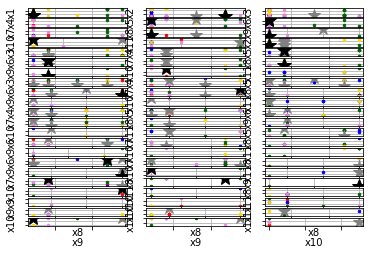

In [96]:
# Print allocated clusters.
#print("Clusters:", clusters)
 
# Display clustering results.
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, samplelist)
visualizer.append_cluster(initial_medoids, samplelist, markersize=12, marker='*', color='gray')
visualizer.append_cluster(medoids, samplelist, markersize=14, marker='*', color='black')
visualizer.show(max_row_size=3)

In [97]:
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
# load 4D data sample 'Iris'
sample_4d = read_sample(FAMOUS_SAMPLES.SAMPLE_IRIS)
sample_4d
type(sample_4d)

list

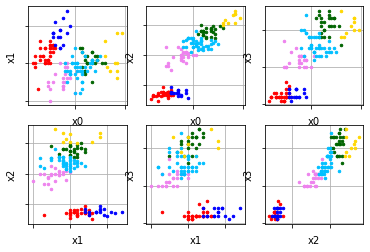

NameError: name 'sample4d' is not defined

In [98]:
from pyclustering.utils import read_sample
from pyclustering.samples.definitions import FAMOUS_SAMPLES
from pyclustering.cluster import cluster_visualizer_multidim
from pyclustering.cluster.xmeans import xmeans
# load 4D data sample 'Iris'
sample_4d = read_sample(FAMOUS_SAMPLES.SAMPLE_IRIS)
# initialize 3 initial centers using K-Means++ algorithm
centers = kmeans_plusplus_initializer(sample_4d, 3).initialize()
# performs cluster analysis using X-Means
xmeans_instance = xmeans(sample_4d, centers)
xmeans_instance.process()
clusters = xmeans_instance.get_clusters()
# visualize obtained clusters in multi-dimensional space
visualizer = cluster_visualizer_multidim()
visualizer.append_clusters(clusters, sample_4d)
visualizer.show(max_row_size=3)

sample4d

In [ ]:
k = 2
# choose medoid 2 and 4 in your C1 and C2 because min(D) in their cluster
initial_medoids = [1,3]
kmedoids_instance = kmedoids(dm, initial_medoids, data_type = 'distance_matrix')
# Run cluster analysis and obtain results.
kmedoids_instance.process()
clusters = kmedoids_instance.get_clusters()
centers = kmedoids_instance.get_medoids()
print(clusters)
# [[1, 0, 2, 5], [3, 4]]
print(centers)
# [1, 3]

In [ ]:
# run PAM from scikit-learn-extra
ske = sklearn_extra.cluster.KMedoids(n_clusters=5, metric="precomputed", method="pam", init="build")
ske.fit(artworkEmotionDistanceMatrix)


In [ ]:
  import sklearn, numpy
  import sklearn_extra.cluster
  
  # Data set 20news
  import sklearn.datasets
  X, y = sklearn.datasets.fetch_20newsgroups_vectorized(return_X_y=True)
  X, y = sklearn.utils.shuffle((X, y), random_state=1)
  
  # Precompute cosine distance matrix
  import sklearn.metrics.pairwise
  diss = sklearn.metrics.pairwise.cosine_distances(X)
  
  # run PAM from scikit-learn-extra
  ske = sklearn_extra.cluster.KMedoids(20, "precomputed", method="pam", init="build")
  ske.fit(diss)
